<a href="https://colab.research.google.com/github/HaikalFrds/Time_Series_Retail_Forecasting/blob/main/Grocery_Sales_Forecasting_Analysis_Synergy_Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
# Data & Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
#import pmdarima as pm
from numpy import log

# Import keras lstm model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Import ARIMA model
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy import stats
import matplotlib.pyplot as plt



# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# Load Data

In [ ]:
df_store = pd.read_csv('store5.csv')
df_store

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.000,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.000,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.000,0,NaN
4,1456,2013-01-01,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,2017-08-15,5,POULTRY,241.011,1,47.57
55568,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57
55570,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


## Prepare Data

## Drop Unused Columns

In [ ]:
# Drop unused columns from df_store
cols_to_drop = ['id', 'store_nbr']
df_store = df_store.drop(columns=[col for col in cols_to_drop if col in df_store.columns])
df_store

,date,family,sales,onpromotion,dcoilwtico
0,2013-01-01,AUTOMOTIVE,0.000,0,NaN
1,2013-01-01,BABY CARE,0.000,0,NaN
2,2013-01-01,BEAUTY,0.000,0,NaN
3,2013-01-01,BEVERAGES,0.000,0,NaN
4,2013-01-01,BOOKS,0.000,0,NaN
...,...,...,...,...,...
55567,2017-08-15,POULTRY,241.011,1,47.57
55568,2017-08-15,PREPARED FOODS,52.121,0,47.57
55569,2017-08-15,PRODUCE,1357.823,4,47.57
55570,2017-08-15,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


# Data Aggregate

In [ ]:
# Convert 'date' column to datetime
df_store['date'] = pd.to_datetime(df_store['date'])

# Filter for 'GROCERY I' family only
grocery_df = df_store[df_store['family'].str.upper() == 'GROCERY I']

# Aggregate daily data to monthly totals
monthly_groceries = (
    grocery_df
    .groupby(pd.Grouper(key='date', freq='MS'))  # 'MS' = month start
    .agg({'sales': 'sum', 'onpromotion': 'sum'})
    .reset_index()
)

# Rename 'date' column to 'month'
monthly_groceries.rename(columns={'date': 'month'}, inplace=True)

# Format 'month' column to show only Year-Month
monthly_groceries['month'] = monthly_groceries['month'].dt.strftime('%Y-%m')

# Sort by month
monthly_groceries = monthly_groceries.sort_values('month')

# Display the result
print(monthly_groceries.to_string())

      month       sales  onpromotion
0   2013-01   87331.000            0
1   2013-02   81325.000            0
2   2013-03   90429.000            0
3   2013-04   84438.000            0
4   2013-05   92975.000            0
5   2013-06   92232.000            0
6   2013-07   95687.000            0
7   2013-08   99879.000            0
8   2013-09   90385.000            0
9   2013-10   88947.000            0
10  2013-11   90417.000            0
11  2013-12  129901.000            0
12  2014-01   92738.000            0
13  2014-02   88400.000            0
14  2014-03   98738.000            0
15  2014-04   88021.000            0
16  2014-05   95749.000            0
17  2014-06   92939.000           35
18  2014-07  100131.000          225
19  2014-08  104447.000          326
20  2014-09   93368.000          158
21  2014-10   95748.000          189
22  2014-11   97244.000          372
23  2014-12  142527.000          448
24  2015-01  100459.000          272
25  2015-02   91712.000          208
2

In [ ]:
type(monthly_groceries)

pandas.core.frame.DataFrame

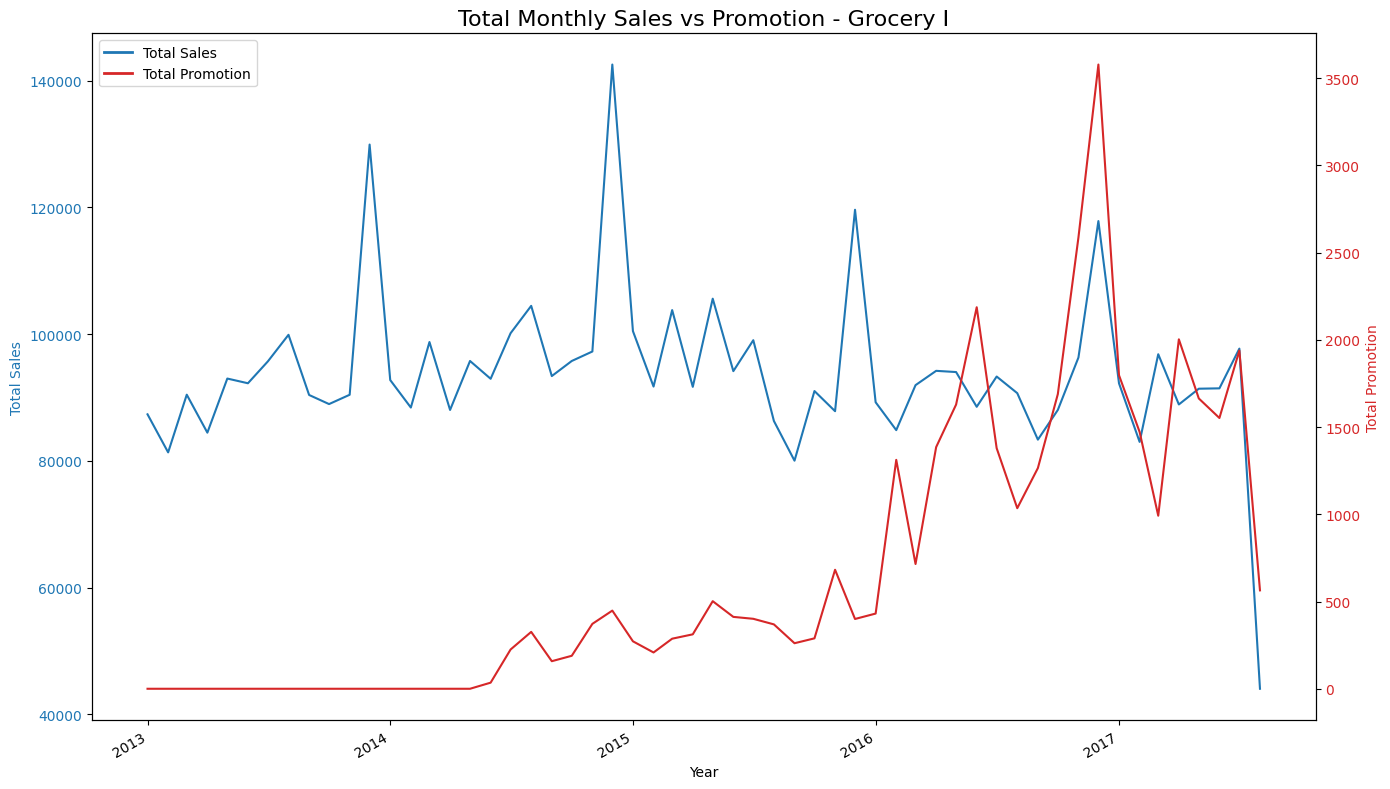

In [ ]:
# Ensure the 'month' column is a datetime type
monthly_groceries['month'] = pd.to_datetime(monthly_groceries['month'])

# Setup figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Total Sales (primary y-axis)
color_sales = 'tab:blue'
ax1.set_title('Total Monthly Sales vs Promotion - Grocery I', fontsize=16)
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Sales', color=color_sales)
sns.lineplot(data=monthly_groceries, x='month', y='sales', ax=ax1, label='Total Sales', color=color_sales)
ax1.tick_params(axis='y', labelcolor=color_sales)

# Format x-axis to show one tick per year
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()

# Plot Total Promotion (secondary y-axis)
ax2 = ax1.twinx()
color_promo = 'tab:red'
ax2.set_ylabel('Total Promotion', color=color_promo)
sns.lineplot(data=monthly_groceries, x='month', y='onpromotion', ax=ax2, label=None, color=color_promo)
ax2.tick_params(axis='y', labelcolor=color_promo)

# Custom legend
custom_lines = [
    plt.Line2D([0], [0], color=color_sales, lw=2, label='Total Sales'),
    plt.Line2D([0], [0], color=color_promo, lw=2, label='Total Promotion')
]
ax1.legend(handles=custom_lines, loc='upper left')

fig.tight_layout()
plt.show()

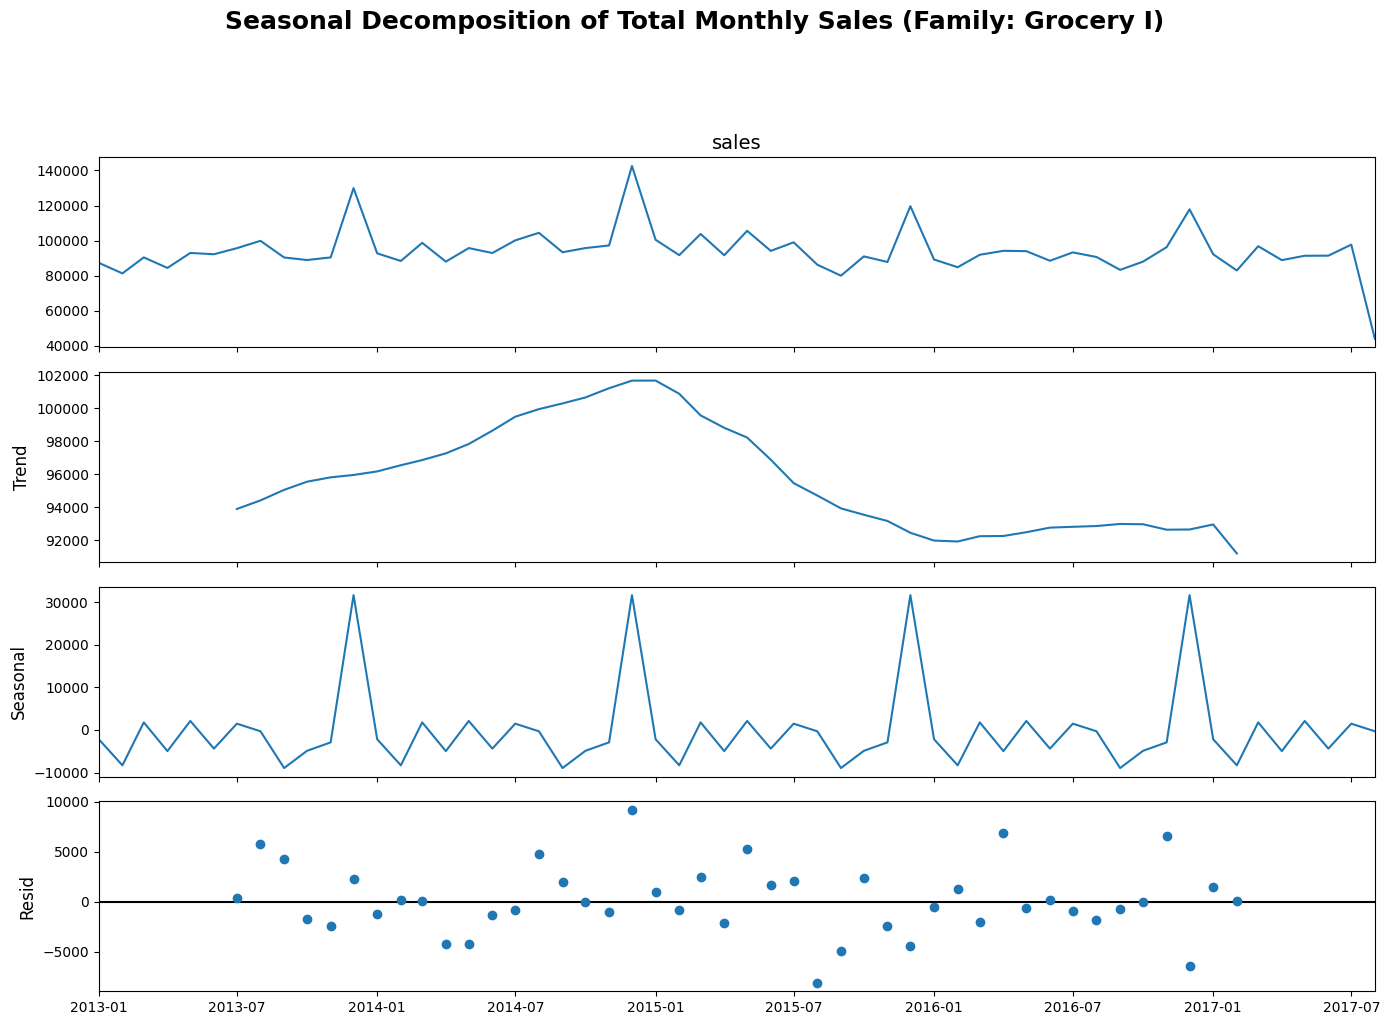

In [ ]:
# Membuat Seasonal Decomposition

# Pastikan 'month' sudah bertipe datetime dan di-set sebagai index
monthly_df = monthly_groceries.copy()
monthly_df['month'] = pd.to_datetime(monthly_df['month'])
monthly_df = monthly_df.set_index('month')

# Pastikan data terurut
monthly_df = monthly_df.sort_index()

# Perform seasonal decomposition (additive model, period 12 for monthly data)
decomposition = seasonal_decompose(monthly_df['sales'], model='additive', period=12)

# Gabungkan hasil decomposisi menjadi DataFrame
decomp_df = pd.DataFrame({
    'observed': decomposition.observed,
    'trend': decomposition.trend,
    'seasonal': decomposition.seasonal,
    'resid': decomposition.resid
})

# Plot the decomposition
plt.rcParams['figure.figsize'] = (14, 10)
fig = decomposition.plot()

# Title & formatting
plt.suptitle('Seasonal Decomposition of Total Monthly Sales (Family: Grocery I)', fontsize=18, fontweight='bold', y=1.02)
for ax in fig.axes:
    ax.title.set_fontsize(14)
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(12)
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# EDA

## Define Target Variable

Target Variable: sales
count        56.000000
mean      93976.458179
std       12881.581894
min       44023.000000
25%       88794.250000
50%       92226.000000
75%       96920.000000
max      142527.000000
Name: sales, dtype: float64


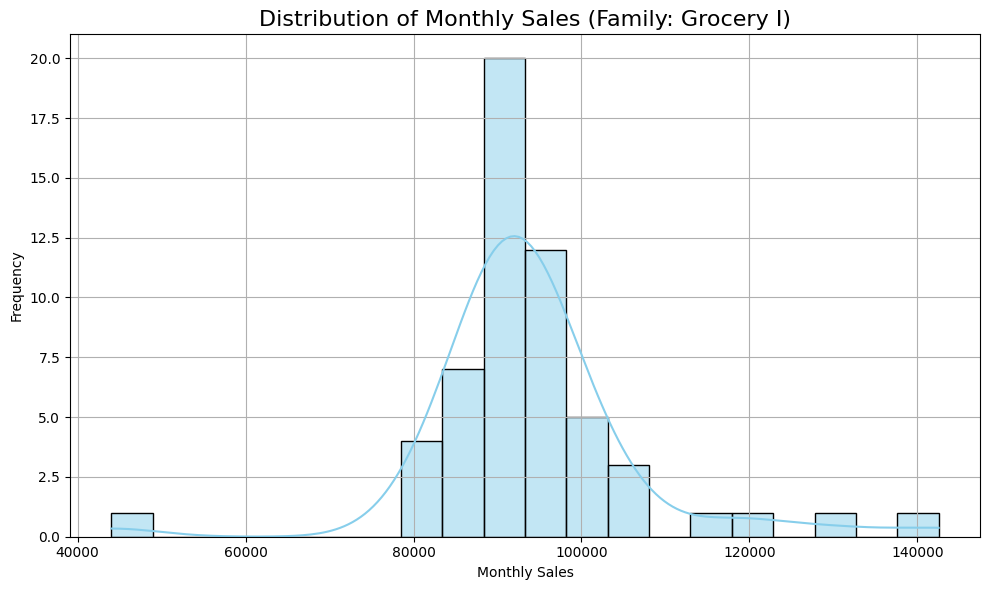

In [ ]:
# Define target variable for monthly data
target = 'sales'
print(f"Target Variable: {target}")

# Summary statistics for monthly sales
print(monthly_groceries[target].describe())

# Plot Distribution of Monthly Sales (Grocery I)
plt.figure(figsize=(10, 6))
sns.histplot(monthly_groceries[target], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Monthly Sales (Family: Grocery I)', fontsize=16)
plt.xlabel('Monthly Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

## Explore Each Variables


--- onpromotion ---
count      56.000000
mean      666.482143
std       806.973425
min         0.000000
25%         0.000000
50%       347.500000
75%      1276.750000
max      3578.000000
Name: onpromotion, dtype: float64


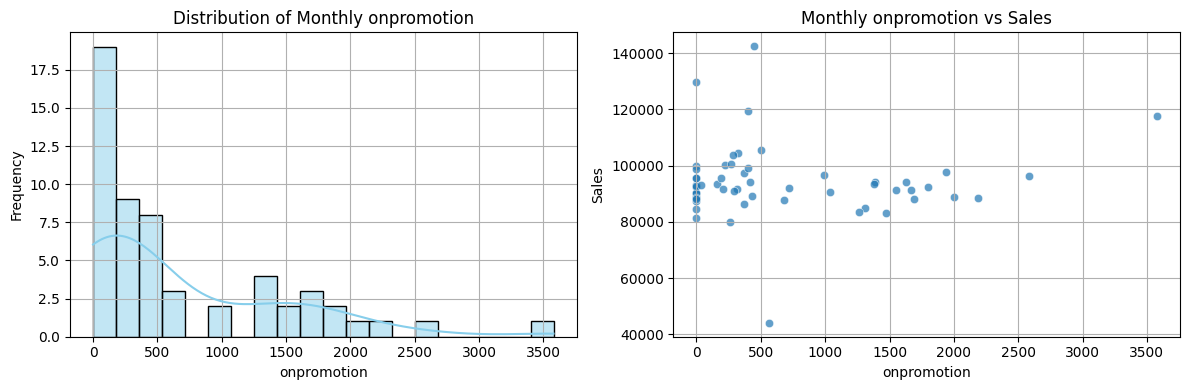

In [ ]:
# Pastikan 'monthly_groceries' sudah tersedia dan memiliki kolom yang sesuai
monthly_numeric_cols = monthly_groceries.select_dtypes(include=['int64', 'float64']).columns.drop('sales')

# Plot each numeric feature (monthly level)
for col in monthly_numeric_cols:
    print(f"\n--- {col} ---")
    print(monthly_groceries[col].describe())

    plt.figure(figsize=(12, 4))

    # Distribution Plot
    plt.subplot(1, 2, 1)
    sns.histplot(monthly_groceries[col], bins=20, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of Monthly {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)

    # Scatter vs Sales
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=monthly_groceries, x=col, y='sales', alpha=0.7)
    plt.title(f'Monthly {col} vs Sales')
    plt.xlabel(col)
    plt.ylabel('Sales')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Rolling Window

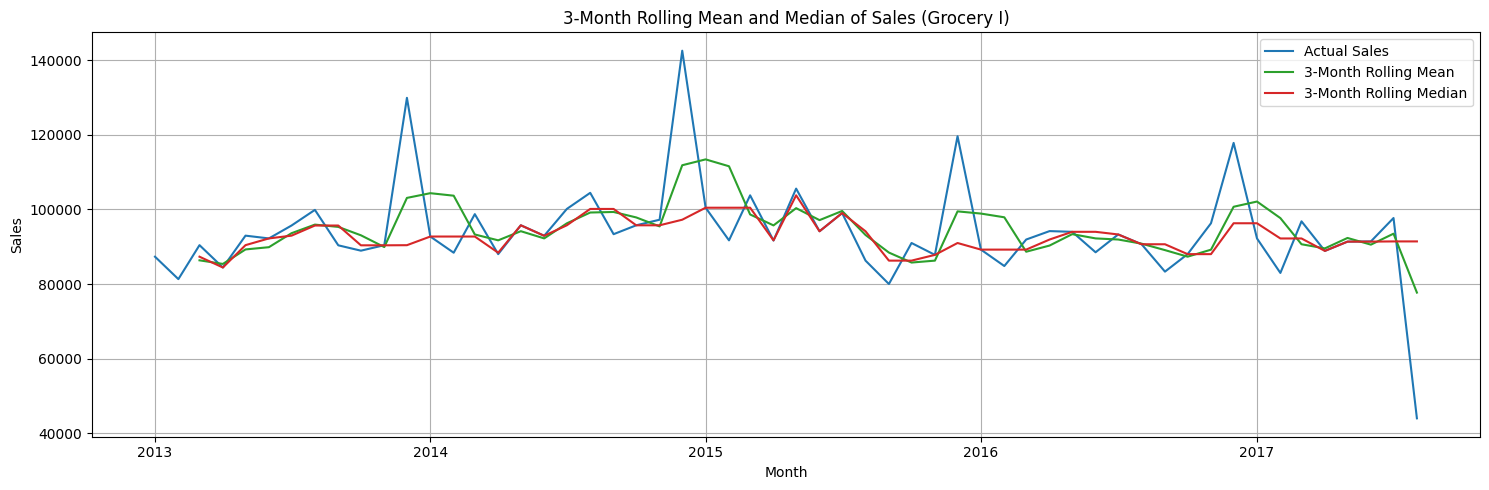

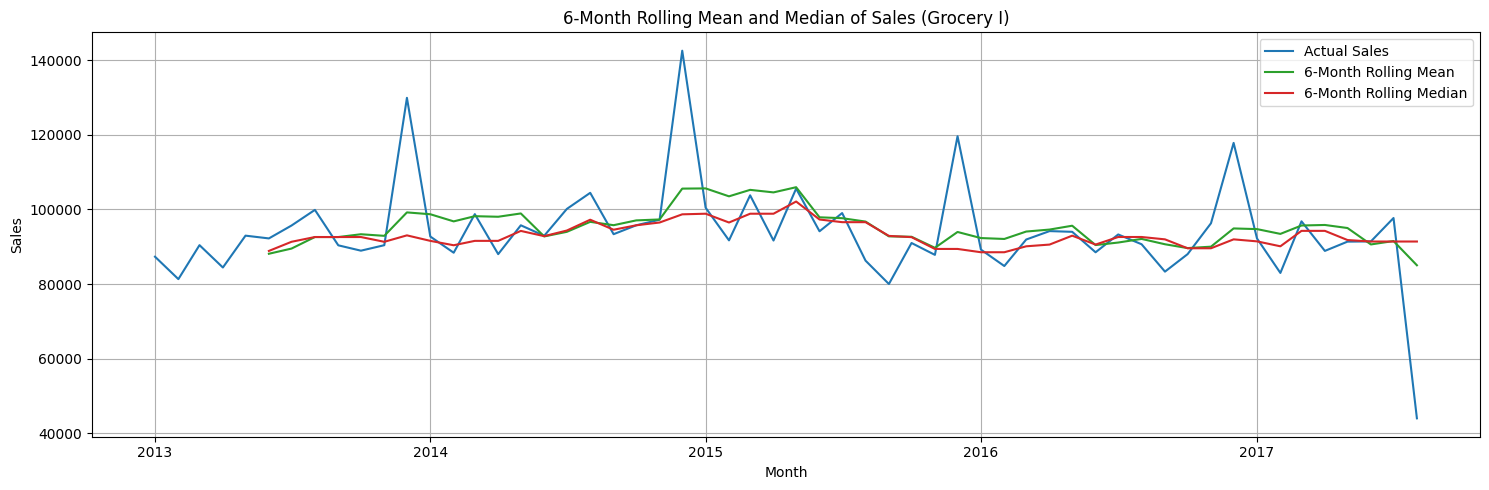

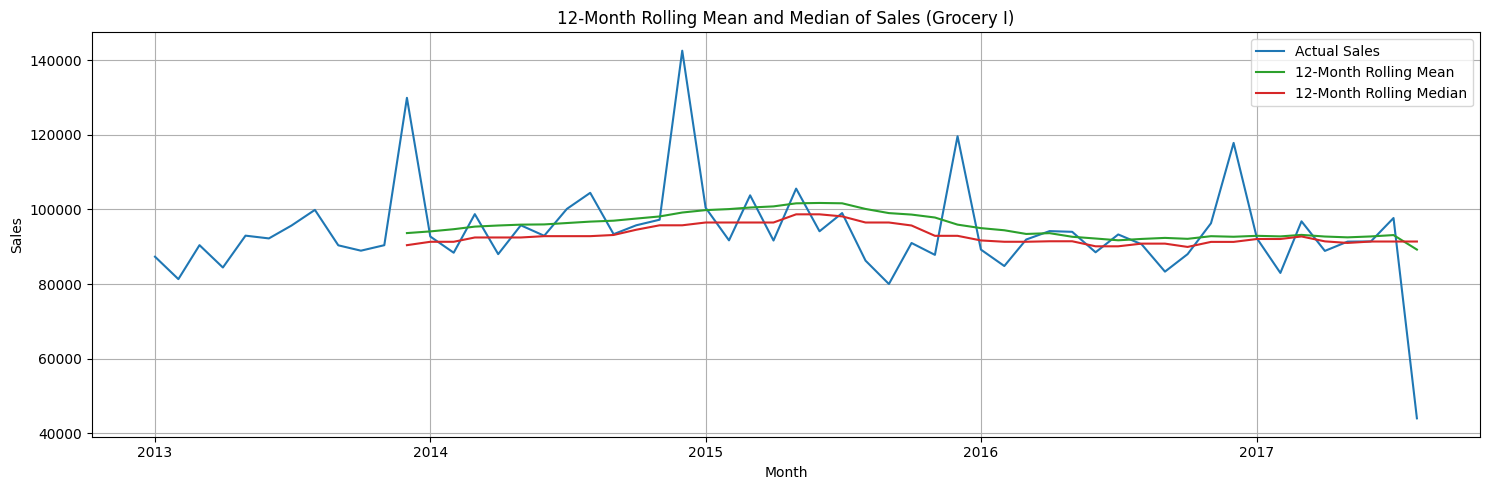

In [ ]:
# Pastikan 'month' bertipe datetime dan terurut
monthly_groceries['month'] = pd.to_datetime(monthly_groceries['month'])
monthly_groceries = monthly_groceries.sort_values('month')

# Tambahkan rolling untuk 3, 6, dan 12 bulan langsung ke monthly_groceries
for window in [3, 6, 12]:
    col_mean = f'rolling_mean_{window}'
    col_median = f'rolling_median_{window}'
    monthly_groceries[col_mean] = monthly_groceries['sales'].rolling(window=window).mean()
    monthly_groceries[col_median] = monthly_groceries['sales'].rolling(window=window).median()

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(monthly_groceries['month'], monthly_groceries['sales'], label='Actual Sales', color='tab:blue')
    plt.plot(monthly_groceries['month'], monthly_groceries[col_mean], label=f'{window}-Month Rolling Mean', color='tab:green')
    plt.plot(monthly_groceries['month'], monthly_groceries[col_median], label=f'{window}-Month Rolling Median', color='tab:red')
    plt.title(f'{window}-Month Rolling Mean and Median of Sales (Grocery I)')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Data Preprocessing

## Checking Missing Values

In [ ]:
# Cek jumlah missing values per kolom di monthly_groceries
missing_values = monthly_groceries.isnull().sum()
print("Missing Values per Column:\n", missing_values)

# Cek persentase missing values
missing_percentage = (monthly_groceries.isnull().mean() * 100).round(2)
print("\nMissing Values Percentage:\n", missing_percentage)

Missing Values per Column:
 month                 0
sales                 0
onpromotion           0
rolling_mean_3        2
rolling_median_3      2
rolling_mean_6        5
rolling_median_6      5
rolling_mean_12      11
rolling_median_12    11
dtype: int64

Missing Values Percentage:
 month                 0.00
sales                 0.00
onpromotion           0.00
rolling_mean_3        3.57
rolling_median_3      3.57
rolling_mean_6        8.93
rolling_median_6      8.93
rolling_mean_12      19.64
rolling_median_12    19.64
dtype: float64


## Handling Missing Values

In [ ]:
# Tentukan kolom rolling yang mau di-drop
rolling_columns = [col for col in monthly_groceries.columns if 'rolling_mean' in col or 'rolling_median' in col]

# Kolom dengan missing values > 30%
missing_percentage = monthly_groceries.isnull().mean() * 100
cols_to_drop = missing_percentage[missing_percentage > 30].index.tolist()

# Gabungkan kolom yang akan di-drop
all_cols_to_drop = list(set(cols_to_drop + rolling_columns))
all_cols_to_drop

['rolling_mean_3',
 'rolling_median_3',
 'rolling_median_6',
 'rolling_mean_6',
 'rolling_mean_12',
 'rolling_median_12']

## Drop unused column dan data dengan missing values >30%

In [ ]:
# Drop kolom dan assign ulang ke dataframe yang sama
monthly_groceries = monthly_groceries.drop(columns=all_cols_to_drop)

# Cek kolom setelah drop
print("Columns after drop:")
print(monthly_groceries.columns)

Columns after drop:
Index(['month', 'sales', 'onpromotion'], dtype='object')


## Feature Engineering / New Features

In [ ]:
# Pastikan kolom 'month' dalam format datetime
monthly_groceries['month'] = pd.to_datetime(monthly_groceries['month'])

# Buat fitur 'year' dan 'month_num' dari kolom 'month'
monthly_groceries['year'] = monthly_groceries['month'].dt.year
monthly_groceries['month_num'] = monthly_groceries['month'].dt.month

# Lihat hasilnya
monthly_groceries.head()

,month,sales,onpromotion,year,month_num
0,2013-01-01,87331.0,0,2013,1
1,2013-02-01,81325.0,0,2013,2
2,2013-03-01,90429.0,0,2013,3
3,2013-04-01,84438.0,0,2013,4
4,2013-05-01,92975.0,0,2013,5


# Lag Features

In [ ]:
# Tambahkan fitur lag untuk kolom 'sales'
lag_list = [1, 2, 3, 6, 12]

for lag in lag_list:
    monthly_groceries[f'lag_{lag}'] = monthly_groceries['sales'].shift(lag)

# Lihat hasilnya
monthly_groceries.head(15)  # Tampilkan lebih banyak baris agar terlihat efek lag


,month,sales,onpromotion,year,month_num,lag_1,lag_2,lag_3,lag_6,lag_12
0,2013-01-01,87331.0,0,2013,1,NaN,NaN,NaN,NaN,NaN
1,2013-02-01,81325.0,0,2013,2,87331.0,NaN,NaN,NaN,NaN
2,2013-03-01,90429.0,0,2013,3,81325.0,87331.0,NaN,NaN,NaN
3,2013-04-01,84438.0,0,2013,4,90429.0,81325.0,87331.0,NaN,NaN
4,2013-05-01,92975.0,0,2013,5,84438.0,90429.0,81325.0,NaN,NaN
5,2013-06-01,92232.0,0,2013,6,92975.0,84438.0,90429.0,NaN,NaN
6,2013-07-01,95687.0,0,2013,7,92232.0,92975.0,84438.0,87331.0,NaN
7,2013-08-01,99879.0,0,2013,8,95687.0,92232.0,92975.0,81325.0,NaN
8,2013-09-01,90385.0,0,2013,9,99879.0,95687.0,92232.0,90429.0,NaN
9,2013-10-01,88947.0,0,2013,10,90385.0,99879.0,95687.0,84438.0,NaN


## Stationarity Data

In [ ]:
result = adfuller(monthly_groceries['sales'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.359176
p-value: 0.979902


# Tambah result yang differencing

In [ ]:
result = adfuller(monthly_groceries['sales'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.038874
p-value: 0.000019


#Correlation

##Menggunakan metode pearsing correlation

In [ ]:
# Hitung korelasi Pearson
correlation_matrix = monthly_groceries.corr(method='pearson')

# Tampilkan hasil korelasi
print(correlation_matrix)

                month     sales  onpromotion      year  month_num     lag_1  \
month        1.000000 -0.143990     0.799004  0.978251   0.074983 -0.027031   
sales       -0.143990  1.000000     0.032139 -0.209653   0.321104  0.027952   
onpromotion  0.799004  0.032139     1.000000  0.770019   0.114602 -0.079481   
year         0.978251 -0.209653     0.770019  1.000000  -0.133482  0.044740   
month_num    0.074983  0.321104     0.114602 -0.133482   1.000000 -0.346283   
lag_1       -0.027031  0.027952    -0.079481  0.044740  -0.346283  1.000000   
lag_2       -0.036021 -0.055209    -0.130167  0.028472  -0.308601  0.054902   
lag_3       -0.027882  0.014178    -0.210345  0.017909  -0.211800 -0.092587   
lag_6       -0.004896 -0.004607    -0.031405  0.008744  -0.059826  0.194555   
lag_12       0.028637  0.649309     0.083834 -0.082195   0.423248 -0.090842   

                lag_2     lag_3     lag_6    lag_12  
month       -0.036021 -0.027882 -0.004896  0.028637  
sales       -0.055209 

#Membuat heatmap dari correlation

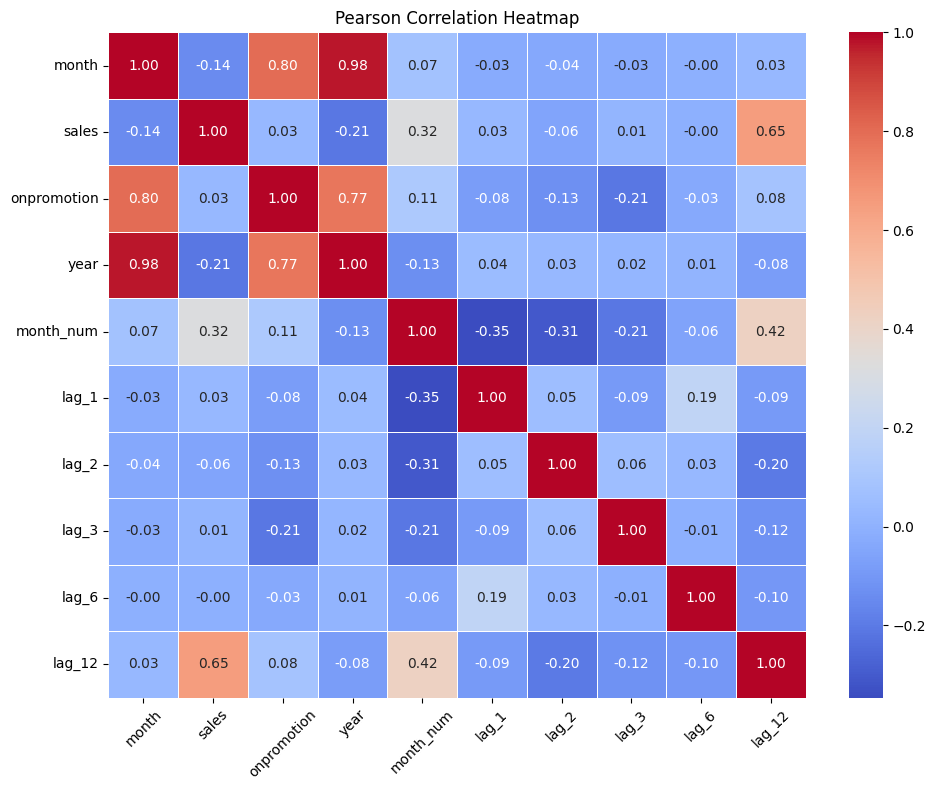

In [ ]:
# Hitung korelasi Pearson
correlation_matrix = monthly_groceries.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Feature Selection

In [ ]:
# Hitung korelasi terhadap target 'sales'
correlation_with_sales = monthly_groceries.corr(method='pearson')['sales'].drop('sales')

# Ambil fitur dengan korelasi absolut tertinggi (positif atau negatif) dengan |korelasi| > 0.3
selected_features = correlation_with_sales[correlation_with_sales.abs() > 0.3].sort_values(ascending=False)

print("Selected features based on correlation with 'sales':")
print(selected_features)

# Opsional: subset data berdasarkan fitur terpilih
X_selected = monthly_groceries[selected_features.index]
y = monthly_groceries['sales']

Selected features based on correlation with 'sales':
lag_12       0.649309
month_num    0.321104
Name: sales, dtype: float64


# Train Test Split

In [ ]:
# Pastikan data diurutkan berdasarkan kolom datetime
monthly_groceries = monthly_groceries.sort_values(by='month')

# Hitung indeks 80% untuk pembagian data
split_index = int(len(monthly_groceries) * 0.8)

# Split data menjadi train dan test
train_df = monthly_groceries.iloc[:split_index]
test_df = monthly_groceries.iloc[split_index:]

# Cek ukuran hasil split
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (44, 10)
Test shape: (12, 10)


Train set berisi 44 baris data (bulan) dan 10 kolom (fitur).

Test set berisi 12 baris data (bulan) dan 10 kolom yang sama.

# Modelling

## ARIMA

### ACF and PACF Plot

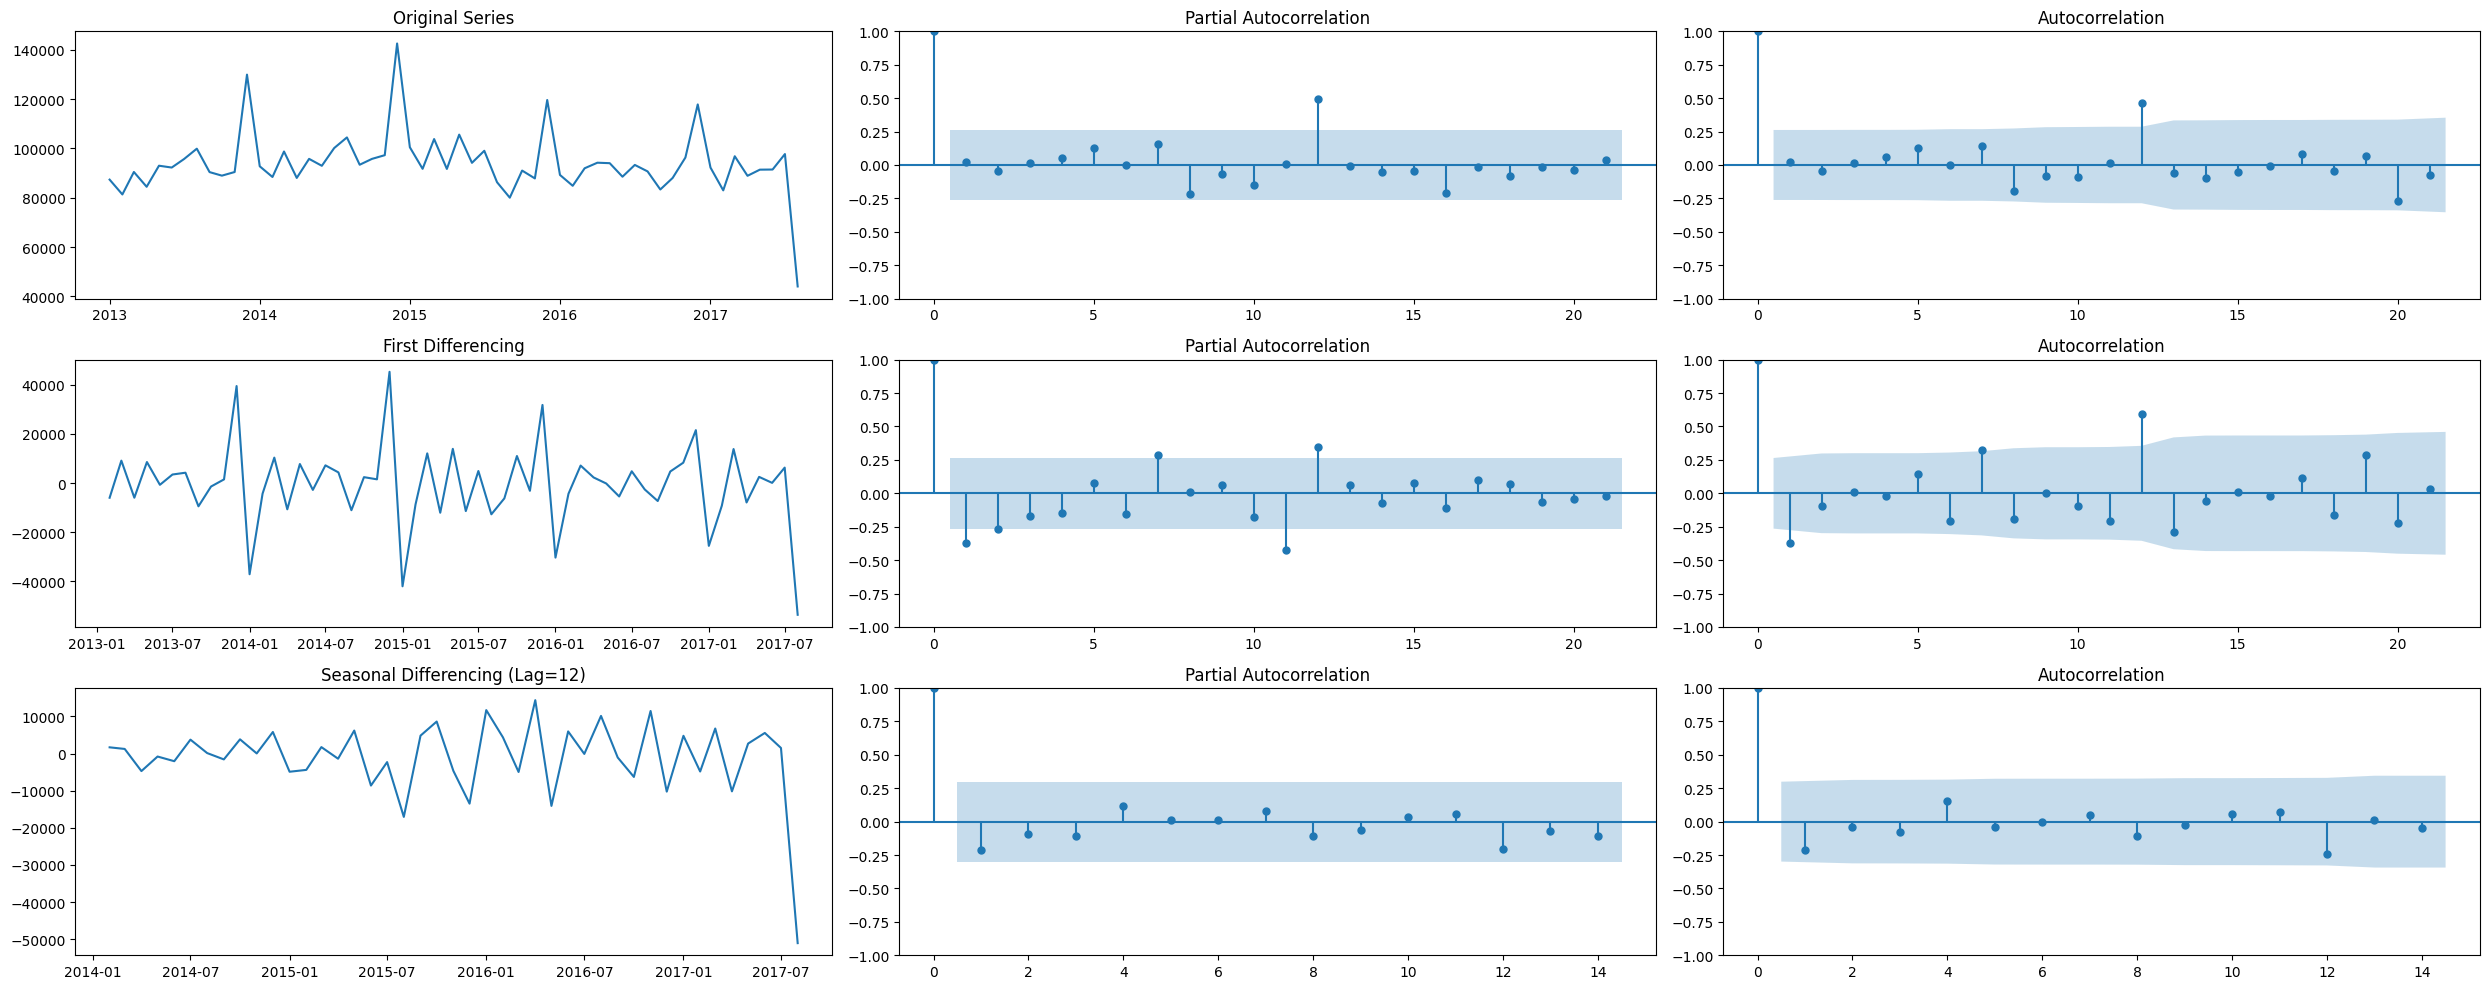

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Pastikan data sudah disortir
monthly_groceries = monthly_groceries.sort_values(by='month')

# Siapkan plot
fig, ax = plt.subplots(3, 3, figsize=(25, 10))

# Plot Original Series
ax[0, 0].set_title('Original Series')
ax[0, 0].plot(monthly_groceries['month'], monthly_groceries['sales'])
plot_pacf(monthly_groceries['sales'], ax=ax[0, 1], lags=21)
plot_acf(monthly_groceries['sales'], ax=ax[0, 2], lags=21)

# First Differencing
diff1 = monthly_groceries['sales'].diff().dropna()
ax[1, 0].set_title('First Differencing')
ax[1, 0].plot(monthly_groceries['month'][1:], diff1)
plot_pacf(diff1, ax=ax[1, 1], lags=21)
plot_acf(diff1, ax=ax[1, 2], lags=21)

# Seasonal Differencing (lag 12)
diff2 = monthly_groceries['sales'].diff().diff(12).dropna()
ax[2, 0].set_title('Seasonal Differencing (Lag=12)')
ax[2, 0].plot(monthly_groceries['month'][13:], diff2)
plot_pacf(diff2, ax=ax[2, 1], lags=14)
plot_acf(diff2, ax=ax[2, 2], lags=14)

plt.tight_layout()
plt.show()


### Define Order (p, d, q)

In [ ]:
# Differenced Data (d=1), sesuai hasil ADF (Augmented Dickey-Fuller) test yang non-stationary
diff_orders = {
    (1, 1, 1), (1, 1, 7), (1, 1, 12),

    (7, 1, 1), (7, 1, 7), (7, 1, 12),

    (11, 1, 1), (11, 1, 7), (11, 1, 12)
    }

# Untuk diff_orders, ini kombinasi ARIMA dengan differencing 1 kali (d=1), sesuai analisa ADF test yang merekomendasikan d=1.

In [ ]:
model = ARIMA(train_df['sales'], order=(1,1,1))

model_fit_cross = model.fit()

print(model_fit_cross.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   44
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -472.218
Date:                Fri, 06 Jun 2025   AIC                            950.437
Time:                        04:47:30   BIC                            955.720
Sample:                             0   HQIC                           952.385
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1155      0.213      0.543      0.587      -0.302       0.533
ma.L1         -0.5639      0.221     -2.554      0.011      -0.997      -0.131
sigma2      1.711e+08   4.84e-10   3.54e+17      0.0

### Auto Arima

In [ ]:
# prompt: buatkan model ARIMA based on exploration order diff_orders dan pilih AIC yang terkecil tanpa menggunakan auto arima

import itertools

# Definisikan range untuk p, d, dan q jika ingin eksplorasi lebih lanjut selain dari diff_orders
# Contoh:
# p_range = range(0, 13) # max lag dari PACF after diff 1
# d_range = range(0, 3)  # bisa 0, 1, atau 2
# q_range = range(0, 13) # max lag dari ACF after diff 1

# Gunakan diff_orders yang sudah ditentukan
diff_orders = { (1, 1, 1), (1, 1, 7), (1, 1, 12),
                 (7, 1, 1), (7, 1, 7), (7, 1, 12),
                 (11, 1, 1), (11, 1, 7), (11, 1, 12) }

best_aic = float('inf')
best_order = None
best_model_fit = None

# Iterasi melalui setiap kombinasi (p, d, q) dalam diff_orders
for order in diff_orders:
    p, d, q = order
    try:
        # Buat model ARIMA dengan order saat ini
        model = ARIMA(train_df['sales'], order=(p, d, q))

        # Fit model
        model_fit = model.fit()

        # Ambil nilai AIC
        aic = model_fit.aic

        print(f'ARIMA{order} AIC: {aic:.3f}')

        # Periksa apakah AIC saat ini lebih kecil dari best_aic yang sudah ditemukan
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model_fit = model_fit

    except Exception as e:
        print(f'Could not fit ARIMA{order}: {e}')
        continue

print(f'\nBest ARIMA model is ARIMA{best_order} with AIC: {best_aic:.3f}')

# Tampilkan summary dari model terbaik
if best_model_fit:
    print("\nSummary of the Best ARIMA Model:")
    print(best_model_fit.summary())

    # Anda juga bisa menyimpan atau menggunakan best_model_fit untuk prediksi
    # Misalnya: predictions = best_model_fit.predict(start=len(train_df), end=len(monthly_groceries)-1)
else:
    print("No suitable ARIMA model found from the specified orders.")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(11, 1, 12) AIC: 985.318
ARIMA(7, 1, 1) AIC: 959.100


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(7, 1, 7) AIC: 981.788
ARIMA(1, 1, 12) AIC: 969.612


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(11, 1, 1) AIC: 964.978


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(11, 1, 7) AIC: 1140.844


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(7, 1, 12) AIC: 977.466
ARIMA(1, 1, 1) AIC: 950.437
ARIMA(1, 1, 7) AIC: 965.724

Best ARIMA model is ARIMA(1, 1, 1) with AIC: 950.437

Summary of the Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   44
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -472.218
Date:                Fri, 06 Jun 2025   AIC                            950.437
Time:                        04:47:36   BIC                            955.720
Sample:                             0   HQIC                           952.385
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1155      0.213     

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model = ARIMA(train_df['sales'], order=(1,1,1), seasonal_order=(1,1,1,12))

model_fit_cross = model.fit()

print(model_fit_cross.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                    SARIMAX Results                                     
Dep. Variable:                            sales   No. Observations:                   44
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -317.181
Date:                          Fri, 06 Jun 2025   AIC                            644.363
Time:                                  04:47:36   BIC                            651.533
Sample:                                       0   HQIC                           646.700
                                           - 44                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1054      3.339      0.032      0.975      -6.438       6.649
ma.L1         -0.1553      3.386     -0.046      0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


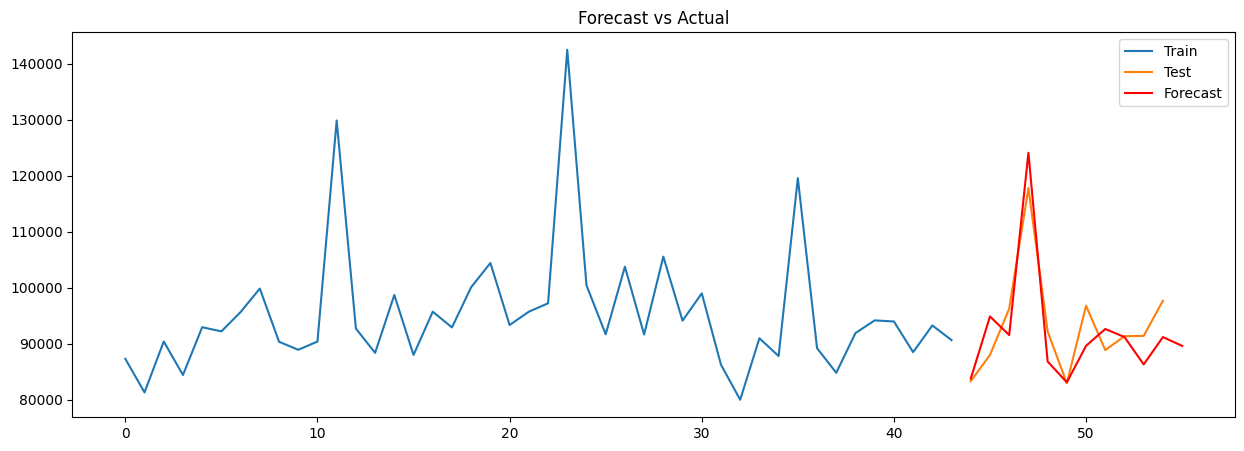

In [ ]:
# Prediction

forecast = model_fit_cross.predict(start=len(train_df), end=len(train_df)+len(test_df)-1, typ='levels')

forecast.index = test_df.index


plt.figure(figsize=(15,5))

plt.title('Forecast vs Actual')

plt.plot(train_df['sales'], label='Train')

plt.plot(test_df['sales'].iloc[:-1], label='Test')

plt.plot(forecast, label='Forecast', color='r')

plt.legend()

### Evaluation

In [ ]:
#Tambah evaluation error di MAE, MAP, MASE

import numpy as np
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_scaled_error(y_true, y_pred):
    # Calculate absolute errors of the naive forecast
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    mae_forecast = np.mean(np.abs(y_true - y_pred))

    # Handle cases where mae_naive is zero (constant actuals)
    if mae_naive == 0:
        return np.inf if mae_forecast > 0 else 0
    return mae_forecast / mae_naive

# Calculate evaluation metrics
mae = mean_absolute_error(test_df['sales'].iloc[:-1], forecast.iloc[:-1])
mape = mean_absolute_percentage_error(test_df['sales'].iloc[:-1], forecast.iloc[:-1])
mase = mean_absolute_scaled_error(test_df['sales'].iloc[:-1], forecast.iloc[:-1])
rmse = np.sqrt(mean_squared_error(test_df['sales'].iloc[:-1], forecast.iloc[:-1]))


print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.3f}%")
print(f"MASE: {mase:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE: 4232.012
MAPE: 4.422%
MASE: 0.424
RMSE: 4972.836


### Forecasting (Optional)

## LSTM

### LSTM Training

In [ ]:
# =============================================================================
# SIMPLE LSTM TIME SERIES PREDICTION FOR GROCERY I SALES
# Architecture: 16 LSTM + 4 Dense units | Training: 150 epochs, LR=0.001
# =============================================================================

# Import additional libraries for LSTM
import random
import os
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '0'

# Statistical tests
import statsmodels.formula.api as smf

# LSTM and preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
try:
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    from keras.optimizers import Adam
    import tensorflow as tf
    tf.random.set_seed(42)
    LSTM_AVAILABLE = True
    print("✅ TensorFlow/Keras tersedia untuk LSTM")
except ImportError:
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense
        from tensorflow.keras.optimizers import Adam
        import tensorflow as tf
        tf.random.set_seed(42)
        LSTM_AVAILABLE = True
        print("✅ TensorFlow/Keras tersedia untuk LSTM")
    except ImportError:
        LSTM_AVAILABLE = False
        print("❌ TensorFlow/Keras tidak tersedia")
        print("   Install dengan: pip install tensorflow")

if LSTM_AVAILABLE:
    print("=== SIMPLE LSTM TIME SERIES PREDICTION FOR GROCERY I SALES ===")
    print("🏗️ Architecture: 16 LSTM + 4 Dense units")
    print("⚙️ Training: 150 epochs, LR=0.001")
    print("🔒 Random seeds set for reproducible results\n")
else:
    print("⚠ LSTM analysis akan dilewati karena TensorFlow tidak tersedia")

✅ TensorFlow/Keras tersedia untuk LSTM
=== SIMPLE LSTM TIME SERIES PREDICTION FOR GROCERY I SALES ===
🏗️ Architecture: 16 LSTM + 4 Dense units
⚙️ Training: 150 epochs, LR=0.001
🔒 Random seeds set for reproducible results



In [ ]:
monthly_groceries.head()

,month,sales,onpromotion,year,month_num,lag_1,lag_2,lag_3,lag_6,lag_12
0,2013-01-01,87331.0,0,2013,1,NaN,NaN,NaN,NaN,NaN
1,2013-02-01,81325.0,0,2013,2,87331.0,NaN,NaN,NaN,NaN
2,2013-03-01,90429.0,0,2013,3,81325.0,87331.0,NaN,NaN,NaN
3,2013-04-01,84438.0,0,2013,4,90429.0,81325.0,87331.0,NaN,NaN
4,2013-05-01,92975.0,0,2013,5,84438.0,90429.0,81325.0,NaN,NaN


In [ ]:
if LSTM_AVAILABLE:
    # =============================================================================
    # 🟢 DATA PREPARATION & FEATURE ENGINEERING FOR LSTM
    # =============================================================================
    print("🟢 DATA PREPARATION & FEATURE ENGINEERING FOR LSTM")
    print("="*60)

    # Reuse data yang sudah di-load dari SARIMA analysis
    print("📂 Reusing data from SARIMA analysis...")
    print(f"Monthly data shape: {monthly_groceries.shape}")
    print(f"Date range: {monthly_groceries['month'].min()} to {monthly_groceries['month'].max()}")

    # --- UJI STASIONERITAS UNTUK LSTM ---
    print("\n--- UJI STASIONERITAS UNTUK LSTM ---")

    # Copy data untuk LSTM processing
    monthly_groceries_lstm = monthly_groceries.copy()
    monthly_groceries_lstm.rename(columns={'date': 'month'}, inplace=True)
    monthly_groceries_lstm = monthly_groceries_lstm.sort_values('month').reset_index(drop=True)

    # ADF Test (Augmented Dickey-Fuller) - reuse function
    def adf_test_lstm(series, title=""):
        result = adfuller(series.dropna())
        print(f'{title}')
        print(f'ADF Statistic: {result[0]:.6f}')
        print(f'p-value: {result[1]:.6f}')
        if result[1] <= 0.05:
            print("✅ Data is STATIONARY")
            return True
        else:
            print("❌ Data is NON-STATIONARY")
            return False

    # Test stationarity on original sales data for LSTM
    is_stationary_lstm = adf_test_lstm(monthly_groceries_lstm['sales'], "ADF Test - Original Sales Data (LSTM)")
else:
    print("⚠ Skipping LSTM data preparation - TensorFlow not available")

🟢 DATA PREPARATION & FEATURE ENGINEERING FOR LSTM
📂 Reusing data from SARIMA analysis...
Monthly data shape: (56, 10)
Date range: 2013-01-01 00:00:00 to 2017-08-01 00:00:00

--- UJI STASIONERITAS UNTUK LSTM ---
ADF Test - Original Sales Data (LSTM)
ADF Statistic: 0.359176
p-value: 0.979902
❌ Data is NON-STATIONARY



--- TRANSFORMASI DATA UNTUK LSTM ---
Data after differencing shape: (44, 12)
ADF Test - After Differencing (LSTM)
ADF Statistic: -4.120939
p-value: 0.000894
✅ Data is STATIONARY


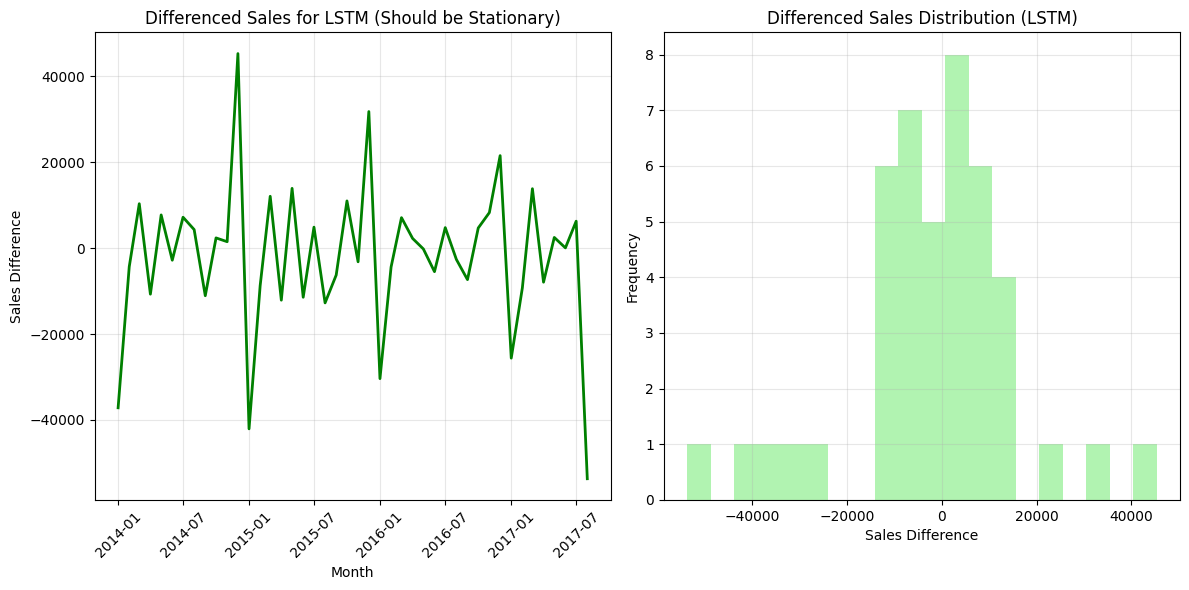

In [ ]:
if LSTM_AVAILABLE:
    # --- TRANSFORMASI DATA UNTUK LSTM ---
    print("\n--- TRANSFORMASI DATA UNTUK LSTM ---")

    # Differencing untuk LSTM (jika non-stasioner)
    df_diff_lstm = monthly_groceries_lstm.copy()
    df_diff_lstm['prev_sales'] = df_diff_lstm['sales'].shift(1)
    df_diff_lstm = df_diff_lstm.dropna()
    df_diff_lstm['sales_diff'] = df_diff_lstm['sales'] - df_diff_lstm['prev_sales']

    print(f"Data after differencing shape: {df_diff_lstm.shape}")

    # Test stationarity after differencing
    is_diff_stationary_lstm = adf_test_lstm(df_diff_lstm['sales_diff'], "ADF Test - After Differencing (LSTM)")

    # Plot differenced data for LSTM
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(df_diff_lstm['month'], df_diff_lstm['sales_diff'], 'g-', linewidth=2)
    plt.title('Differenced Sales for LSTM (Should be Stationary)')
    plt.xlabel('Month')
    plt.ylabel('Sales Difference')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(df_diff_lstm['sales_diff'], bins=20, alpha=0.7, color='lightgreen')
    plt.title('Differenced Sales Distribution (LSTM)')
    plt.xlabel('Sales Difference')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
if LSTM_AVAILABLE:
    # --- LAG FEATURES CREATION FOR LSTM ---
    print("\n--- LAG FEATURES CREATION FOR LSTM ---")
    print("Time Series → Supervised Learning")

    # Create supervised learning dataset
    df_supervised_lstm = df_diff_lstm[['month', 'sales', 'sales_diff']].copy()

    # Add seasonal features
    df_supervised_lstm['month_num'] = df_supervised_lstm['month'].dt.month
    df_supervised_lstm['quarter'] = df_supervised_lstm['month'].dt.quarter

    # Add rolling statistics
    df_supervised_lstm['rolling_mean_3'] = df_supervised_lstm['sales_diff'].rolling(window=3, min_periods=1).mean()
    df_supervised_lstm['rolling_mean_6'] = df_supervised_lstm['sales_diff'].rolling(window=6, min_periods=1).mean()

    # Add lag features (Lag_1, Lag_2, ..., Lag_n)
    n_lags = 3
    print(f"Creating lag features for LSTM: Lag_1 to Lag_{n_lags}")
    for lag in range(1, n_lags + 1):
        df_supervised_lstm[f'lag_{lag}'] = df_supervised_lstm['sales_diff'].shift(lag)

    # Drop null values
    df_supervised_lstm = df_supervised_lstm.dropna().reset_index(drop=True)
    print(f"Supervised dataset shape for LSTM: {df_supervised_lstm.shape}")
    print(f"Features created: {[col for col in df_supervised_lstm.columns if 'lag_' in col]}")

    # --- FEATURE IMPORTANCE ANALYSIS FOR LSTM ---
    print("\n--- FEATURE IMPORTANCE ANALYSIS FOR LSTM ---")

    # Test different lag combinations
    lag_combinations = [
        ['lag_1'],
        ['lag_1', 'lag_2', 'lag_3'],
        ['lag_1', 'lag_2', 'lag_3', 'month_num'],
        ['lag_1', 'lag_2', 'lag_3', 'month_num', 'rolling_mean_3'],
    ]

    print("Feature importance analysis for LSTM (Adjusted R-squared):")
    best_r_squared = 0
    for i, lags in enumerate(lag_combinations):
        try:
            formula = f"sales_diff ~ {' + '.join(lags)}"
            model = smf.ols(formula=formula, data=df_supervised_lstm)
            model_fit = model.fit()
            r_squared = model_fit.rsquared_adj
            if r_squared > best_r_squared:
                best_r_squared = r_squared
            print(f"Combination {i+1}: {r_squared:.4f} (features: {len(lags)})")
        except:
            print(f"Combination {i+1}: Error in calculation")

    print(f"✅ Best R-squared for LSTM: {best_r_squared:.4f}")

    # --- PREPARE MODEL DATASET FOR LSTM ---
    print("\n--- PREPARE MODEL DATASET FOR LSTM ---")

    # Prepare model dataset
    exclude_cols = ['month', 'sales']
    feature_cols_lstm = [col for col in df_supervised_lstm.columns if col not in exclude_cols]
    df_model_lstm = df_supervised_lstm[feature_cols_lstm].copy()

    # Handle missing values
    df_model_lstm = df_model_lstm.ffill().bfill()

    print(f"Model dataset shape for LSTM: {df_model_lstm.shape}")
    print(f"Features for LSTM model: {len(feature_cols_lstm)}")
    print(f"Feature columns: {feature_cols_lstm}")


--- LAG FEATURES CREATION FOR LSTM ---
Time Series → Supervised Learning
Creating lag features for LSTM: Lag_1 to Lag_3
Supervised dataset shape for LSTM: (41, 10)
Features created: ['lag_1', 'lag_2', 'lag_3']

--- FEATURE IMPORTANCE ANALYSIS FOR LSTM ---
Feature importance analysis for LSTM (Adjusted R-squared):
Combination 1: 0.1393 (features: 1)
Combination 2: 0.2261 (features: 3)
Combination 3: 0.3717 (features: 4)
Combination 4: 1.0000 (features: 5)
✅ Best R-squared for LSTM: 1.0000

--- PREPARE MODEL DATASET FOR LSTM ---
Model dataset shape for LSTM: (41, 8)
Features for LSTM model: 8
Feature columns: ['sales_diff', 'month_num', 'quarter', 'rolling_mean_3', 'rolling_mean_6', 'lag_1', 'lag_2', 'lag_3']


## **12. LSTM Training & Architechture**

Training the LSTM model and performing validation on test data.

In [ ]:
if LSTM_AVAILABLE:
    print("\n\n🔵 LSTM MODEL ARCHITECTURE & TRAINING")
    print("="*60)

    # --- TRAIN-VALIDATION SPLIT (TEMPORAL) ---
    print("--- TRAIN-VALIDATION SPLIT (TEMPORAL) ---")

    test_size_lstm = 12  # Last 12 months for testing (same as SARIMA)
    train_data_lstm = df_model_lstm.iloc[:-test_size_lstm].values
    test_data_lstm = df_model_lstm.iloc[-test_size_lstm:].values

    print(f"LSTM Train set shape: {train_data_lstm.shape}")
    print(f"LSTM Test set shape: {test_data_lstm.shape}")

    # Apply MinMax Scaling
    scaler_lstm = MinMaxScaler(feature_range=(-1, 1))
    train_scaled_lstm = scaler_lstm.fit_transform(train_data_lstm)
    test_scaled_lstm = scaler_lstm.transform(test_data_lstm)
    print("✅ LSTM data scaled to range (-1, 1)")

    # Prepare LSTM input format
    X_train_lstm = train_scaled_lstm[:, 1:]  # features (lag features)
    y_train_lstm = train_scaled_lstm[:, 0:1]  # target (sales_diff)
    X_test_lstm = test_scaled_lstm[:, 1:]
    y_test_lstm = test_scaled_lstm[:, 0:1]

    # Reshape for LSTM (samples, timesteps, features)
    X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], 1, X_train_lstm.shape[1])
    X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], 1, X_test_lstm.shape[1])

    print(f"X_train_lstm shape: {X_train_lstm.shape}")
    print(f"y_train_lstm shape: {y_train_lstm.shape}")
    print(f"X_test_lstm shape: {X_test_lstm.shape}")
    print(f"y_test_lstm shape: {y_test_lstm.shape}")
else:
    print("⚠ Skipping LSTM training - TensorFlow not available")



🔵 LSTM MODEL ARCHITECTURE & TRAINING
--- TRAIN-VALIDATION SPLIT (TEMPORAL) ---
LSTM Train set shape: (29, 8)
LSTM Test set shape: (12, 8)
✅ LSTM data scaled to range (-1, 1)
X_train_lstm shape: (29, 1, 7)
y_train_lstm shape: (29, 1)
X_test_lstm shape: (12, 1, 7)
y_test_lstm shape: (12, 1)


In [ ]:
if LSTM_AVAILABLE:
    # --- LSTM ARCHITECTURE ---
    print("\n--- LSTM ARCHITECTURE ---")

    # Sequential Model
    model_lstm = Sequential()

    # LSTM Layer (16 neurons)
    model_lstm.add(LSTM(16, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False))

    # Dense Output Layers
    model_lstm.add(Dense(4, activation='relu'))
    model_lstm.add(Dense(1))

    print("LSTM Model Architecture:")
    print("  - Sequential Model")
    print("  - LSTM Layer: 16 neurons")
    print("  - Dense Layer: 4 neurons (relu)")
    print("  - Output Layer: 1 neuron")

    # --- HYPERPARAMETERS ---
    print("\n--- LSTM HYPERPARAMETERS ---")

    # Learning Rate
    learning_rate = 0.001
    print(f"Learning Rate: {learning_rate}")

    # Batch Size
    batch_size = 1
    print(f"Batch Size: {batch_size}")

    # Epochs
    epochs = 150
    print(f"Epochs: {epochs}")

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model_lstm.compile(loss='mean_squared_error', optimizer=optimizer)
    print("Loss: MSE, Optimizer: Adam")

    # Model summary
    print("\n📋 LSTM Model Summary:")
    model_lstm.summary()


--- LSTM ARCHITECTURE ---
LSTM Model Architecture:
  - Sequential Model
  - LSTM Layer: 16 neurons
  - Dense Layer: 4 neurons (relu)
  - Output Layer: 1 neuron

--- LSTM HYPERPARAMETERS ---
Learning Rate: 0.001
Batch Size: 1
Epochs: 150
Loss: MSE, Optimizer: Adam

📋 LSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,609 (6.29 KB)

 Trainable params: 1,609 (6.29 KB)

 Non-trainable params: 0 (0.00 B)


--- LSTM TRAINING PROCESS ---
🚀 Starting LSTM training...
Epoch 1/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1328
Epoch 2/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1227
Epoch 3/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1196
Epoch 4/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1170
Epoch 5/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1143
Epoch 6/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1103
Epoch 7/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1065
Epoch 8/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1027
Epoch 9/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0991
Epoch 10/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0956
Epoch 11/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0921
Epoch 12/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0887
Epoch 13/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0854
Epoch 14/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0822
Epoch 15/150

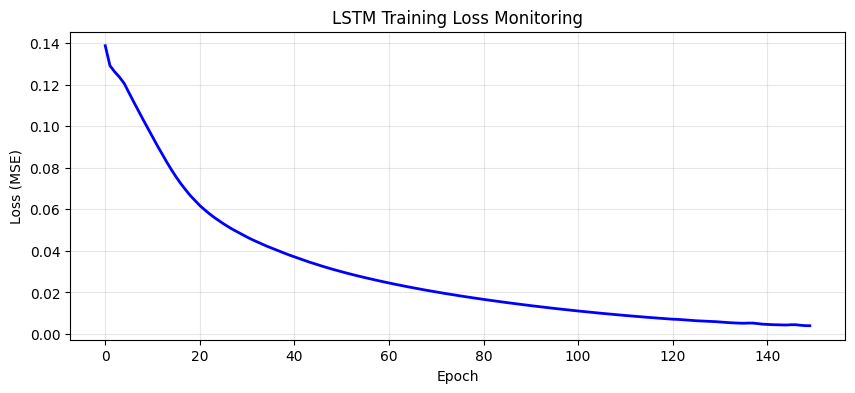

Final LSTM training loss: 0.003988


In [ ]:
if LSTM_AVAILABLE:
    # --- TRAINING PROCESS ---
    print("\n--- LSTM TRAINING PROCESS ---")

    # Monitor Training Loss
    print("🚀 Starting LSTM training...")
    try:
        history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)
    except TypeError:
        history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, nb_epoch=epochs, batch_size=batch_size, verbose=1, shuffle=False)

    print("✅ LSTM training completed!")

    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(history_lstm.history['loss'], 'b-', linewidth=2)
    plt.title('LSTM Training Loss Monitoring')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Final LSTM training loss: {history_lstm.history['loss'][-1]:.6f}")

In [ ]:
if LSTM_AVAILABLE:
    # =============================================================================
    # 🟣 LSTM EVALUATION & VALIDATION
    # =============================================================================
    print("\n\n🟣 LSTM EVALUATION & VALIDATION")
    print("="*60)

    # --- MAKE PREDICTIONS ---
    print("--- MAKE LSTM PREDICTIONS ---")

    # Predict on test set
    y_pred_lstm = model_lstm.predict(X_test_lstm)
    print(f"LSTM Predictions shape: {y_pred_lstm.shape}")

    # --- INVERSE TRANSFORMATION ---
    print("\n--- INVERSE TRANSFORMATION ---")

    # Reshape predictions for inverse scaling
    y_pred_reshaped_lstm = y_pred_lstm.reshape(y_pred_lstm.shape[0], 1, y_pred_lstm.shape[1])

    # Rebuild test set for inverse transform
    pred_test_set_lstm = []
    for index in range(0, len(y_pred_reshaped_lstm)):
        concat_data = np.concatenate([y_pred_reshaped_lstm[index], X_test_lstm[index]], axis=1)
        pred_test_set_lstm.append(concat_data)

    pred_test_set_lstm = np.array(pred_test_set_lstm)
    pred_test_set_lstm = pred_test_set_lstm.reshape(pred_test_set_lstm.shape[0], pred_test_set_lstm.shape[2])

    # Inverse transform
    pred_test_set_inverted_lstm = scaler_lstm.inverse_transform(pred_test_set_lstm)

    # Convert back to actual sales values
    sales_dates_lstm = list(df_supervised_lstm['month'].iloc[-(test_size_lstm+1):])
    actual_sales_lstm = list(df_supervised_lstm['sales'].iloc[-(test_size_lstm+1):])

    result_list_lstm = []
    for index in range(0, len(pred_test_set_inverted_lstm)):
        result_dict = {}
        result_dict['pred_value'] = int(pred_test_set_inverted_lstm[index][0] + actual_sales_lstm[index])
        result_dict['month'] = sales_dates_lstm[index+1]
        result_list_lstm.append(result_dict)

    df_result_lstm = pd.DataFrame(result_list_lstm)
    print("✅ LSTM inverse transformation completed!")



🟣 LSTM EVALUATION & VALIDATION
--- MAKE LSTM PREDICTIONS ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
LSTM Predictions shape: (12, 1)

--- INVERSE TRANSFORMATION ---
✅ LSTM inverse transformation completed!


In [ ]:
# Fungsi untuk menghitung metrik akurasi (definisikan di luar blok if)
def calculate_accuracy_metrics(actual, predicted):
    me = np.mean(actual - predicted)
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - predicted))
    mpe = np.mean((actual - predicted) / actual) * 100
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    naive_forecast = np.roll(actual, 1)[1:]
    mase = mae / np.mean(np.abs(actual[1:] - naive_forecast))
    return {
        'ME': me, 'MSE': mse, 'RMSE': rmse,
        'MAE': mae, 'MPE': mpe, 'MAPE': mape, 'MASE': mase
    }

# Evaluasi LSTM
if LSTM_AVAILABLE:
    print("\n--- LSTM PERFORMANCE METRICS ---")

    # Merge dengan data aktual
    df_sales_pred_lstm = pd.merge(
        monthly_groceries_lstm[['month', 'sales']],
        df_result_lstm,
        on='month', how='left'
    )
    predicted_data_lstm = df_sales_pred_lstm.dropna()

    if not predicted_data_lstm.empty:
        actual_sales_test_lstm = predicted_data_lstm['sales'].values
        pred_sales_lstm = predicted_data_lstm['pred_value'].values

        accuracy_metrics_lstm = calculate_accuracy_metrics(actual_sales_test_lstm, pred_sales_lstm)

        print("🎯 HASIL EVALUASI AKURASI MODEL LSTM (BULANAN):")
        print("="*50)
        print(f"Model: LSTM (16 neurons + 4 dense)")
        print(f"Jumlah prediksi: {len(actual_sales_test_lstm)} bulan\n")
        print("📊 METRIK AKURASI LSTM:")
        print("-"*50)
        print(f"ME        RMSE      MAE       MPE          MAPE       MASE")
        print(f"{accuracy_metrics_lstm['ME']:.6f} {accuracy_metrics_lstm['RMSE']:.5f} "
              f"{accuracy_metrics_lstm['MAE']:.5f} {accuracy_metrics_lstm['MPE']:.8f} "
              f"{accuracy_metrics_lstm['MAPE']:.7f} {accuracy_metrics_lstm['MASE']:.7f}")

        print(f"\n📋 PENJELASAN METRIK LSTM (BULANAN):")
        print(f"- ME (Mean Error): {accuracy_metrics_lstm['ME']:.4f}")
        print(f"- MSE (Mean Square Error): {accuracy_metrics_lstm['MSE']:.4f}")
        print(f"- RMSE (Root Mean Square Error): {accuracy_metrics_lstm['RMSE']:.4f}")
        print(f"- MAE (Mean Absolute Error): {accuracy_metrics_lstm['MAE']:.4f}")
        print(f"- MPE (Mean Percentage Error): {accuracy_metrics_lstm['MPE']:.4f}%")
        print(f"- MAPE (Mean Absolute Percentage Error): {accuracy_metrics_lstm['MAPE']:.4f}%")
        print(f"- MASE (Mean Absolute Scale Error): {accuracy_metrics_lstm['MASE']:.4f}")

        print(f"\n💡 INTERPRETASI HASIL LSTM (PREDIKSI BULANAN):")
        if accuracy_metrics_lstm['MAPE'] < 10:
            print("✓ Model LSTM memiliki akurasi yang sangat baik untuk prediksi bulanan (MAPE < 10%)")
        elif accuracy_metrics_lstm['MAPE'] < 20:
            print("✓ Model LSTM memiliki akurasi yang baik untuk prediksi bulanan (MAPE < 20%)")
        elif accuracy_metrics_lstm['MAPE'] < 30:
            print("⚠ Model LSTM memiliki akurasi yang cukup untuk prediksi bulanan (MAPE < 30%)")
        else:
            print("⚠ Model LSTM memiliki akurasi yang kurang baik untuk prediksi bulanan (MAPE > 30%)")
    else:
        print("❌ Tidak ada data prediksi LSTM yang valid untuk evaluasi.")
        accuracy_metrics_lstm = {
            'ME': np.nan, 'MSE': np.nan, 'RMSE': np.nan,
            'MAE': np.nan, 'MPE': np.nan, 'MAPE': np.nan, 'MASE': np.nan
        }
else:
    print("⚠ LSTM evaluation skipped - TensorFlow not available.")
    accuracy_metrics_lstm = {
        'ME': np.nan, 'MSE': np.nan, 'RMSE': np.nan,
        'MAE': np.nan, 'MPE': np.nan, 'MAPE': np.nan, 'MASE': np.nan
    }
    predicted_data_lstm = pd.DataFrame()


--- LSTM PERFORMANCE METRICS ---
🎯 HASIL EVALUASI AKURASI MODEL LSTM (BULANAN):
Model: LSTM (16 neurons + 4 dense)
Jumlah prediksi: 12 bulan

📊 METRIK AKURASI LSTM:
--------------------------------------------------
ME        RMSE      MAE       MPE          MAPE       MASE
-996.083333 2282.98735 1204.91667 -1.79420774 2.0272741 0.0862969

📋 PENJELASAN METRIK LSTM (BULANAN):
- ME (Mean Error): -996.0833
- MSE (Mean Square Error): 5212031.2500
- RMSE (Root Mean Square Error): 2282.9874
- MAE (Mean Absolute Error): 1204.9167
- MPE (Mean Percentage Error): -1.7942%
- MAPE (Mean Absolute Percentage Error): 2.0273%
- MASE (Mean Absolute Scale Error): 0.0863

💡 INTERPRETASI HASIL LSTM (PREDIKSI BULANAN):
✓ Model LSTM memiliki akurasi yang sangat baik untuk prediksi bulanan (MAPE < 10%)



--- LSTM RESIDUAL ANALYSIS ---


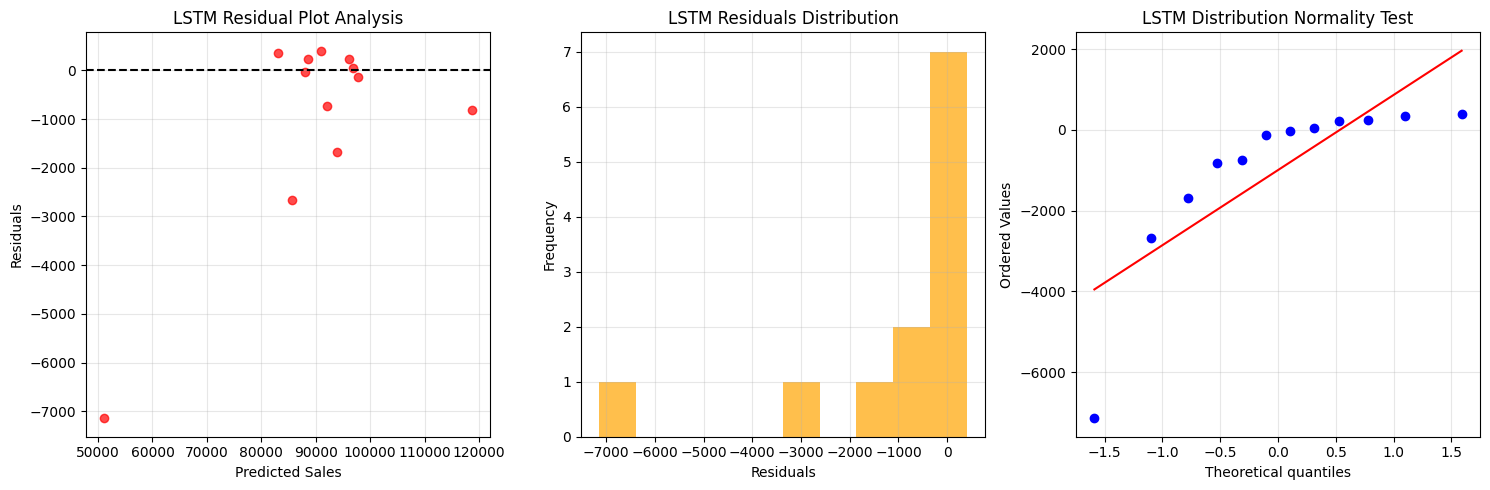


--- HASIL PREDIKSI LSTM ---
LSTM Prediction Results:
        month     sales  pred_value
44 2016-09-01   83334.0     82989.0
45 2016-10-01   88021.0     88057.0
46 2016-11-01   96295.0     96060.0
47 2016-12-01  117826.0    118642.0
48 2017-01-01   92220.0     93900.0
49 2017-02-01   82980.0     85647.0
50 2017-03-01   96812.0     96766.0
51 2017-04-01   88886.0     88660.0
52 2017-05-01   91373.0     92110.0
53 2017-06-01   91430.0     91029.0
54 2017-07-01   97700.0     97829.0
55 2017-08-01   44023.0     51164.0


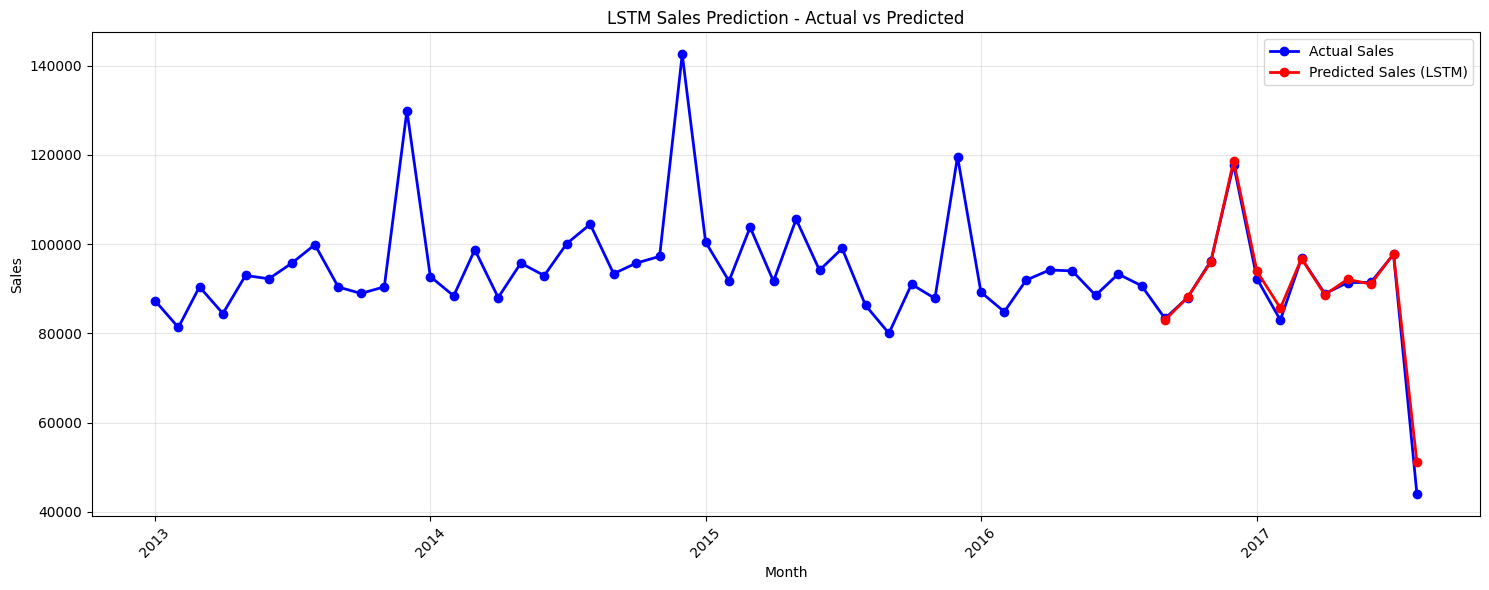

In [ ]:
if LSTM_AVAILABLE and len(predicted_data_lstm) > 0:
    # --- LSTM RESIDUAL ANALYSIS ---
    print("\n--- LSTM RESIDUAL ANALYSIS ---")

    residuals_lstm = actual_sales_test_lstm - pred_sales_lstm

    plt.figure(figsize=(15, 5))

    # Residual Plot Analysis
    plt.subplot(1, 3, 1)
    plt.scatter(pred_sales_lstm, residuals_lstm, alpha=0.7, color='red')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Residuals')
    plt.title('LSTM Residual Plot Analysis')
    plt.grid(True, alpha=0.3)

    # Residuals Distribution
    plt.subplot(1, 3, 2)
    plt.hist(residuals_lstm, bins=10, alpha=0.7, color='orange')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('LSTM Residuals Distribution')
    plt.grid(True, alpha=0.3)

    # Q-Q Plot
    plt.subplot(1, 3, 3)
    stats.probplot(residuals_lstm, dist="norm", plot=plt)
    plt.title('LSTM Distribution Normality Test')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- LSTM RESULTS VISUALIZATION ---
    print("\n--- HASIL PREDIKSI LSTM ---")

    print("LSTM Prediction Results:")
    print(df_sales_pred_lstm[['month', 'sales', 'pred_value']].tail(test_size_lstm))

    # Plot actual vs predicted for LSTM
    plt.figure(figsize=(15, 6))
    plt.plot(df_sales_pred_lstm['month'], df_sales_pred_lstm['sales'], 'bo-', label='Actual Sales', linewidth=2, markersize=6)
    plt.plot(df_sales_pred_lstm['month'], df_sales_pred_lstm['pred_value'], 'ro-', label='Predicted Sales (LSTM)', linewidth=2, markersize=6)
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.title('LSTM Sales Prediction - Actual vs Predicted')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## **13. Model Comparison & Final Results**

Comprehensive comparison between SARIMA and LSTM models with final recommendations.

In [ ]:
print("\n" + "="*80)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*80)

print("\n🔀 SARIMA vs LSTM PERFORMANCE COMPARISON")
print("-"*60)

# Check if both models have valid results
sarima_valid = 'accuracy_metrics_sarima' in locals() and not np.isnan(accuracy_metrics_sarima['MAPE'])
lstm_valid = LSTM_AVAILABLE and not np.isnan(accuracy_metrics_lstm['MAPE'])

if sarima_valid and lstm_valid:
    # Create comparison dataframe
    comparison_data = {
        'Metric': ['MAE', 'RMSE', 'MAPE (%)', 'MASE'],
        'SARIMA': [
            f"{accuracy_metrics_sarima['MAE']:.2f}",
            f"{accuracy_metrics_sarima['RMSE']:.2f}",
            f"{accuracy_metrics_sarima['MAPE']:.2f}",
            f"{accuracy_metrics_sarima['MASE']:.3f}"
        ],
        'LSTM': [
            f"{accuracy_metrics_lstm['MAE']:.2f}",
            f"{accuracy_metrics_lstm['RMSE']:.2f}",
            f"{accuracy_metrics_lstm['MAPE']:.2f}",
            f"{accuracy_metrics_lstm['MASE']:.3f}"
        ]
    }

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    # Determine best model
    sarima_mape = accuracy_metrics_sarima['MAPE']
    lstm_mape = accuracy_metrics_lstm['MAPE']

    if sarima_mape < lstm_mape:
        best_model_final = "SARIMA"
        mape_diff = lstm_mape - sarima_mape
        improvement = f"SARIMA outperforms LSTM by {mape_diff:.2f}% MAPE"
        winner_metrics = accuracy_metrics_sarima
    else:
        best_model_final = "LSTM"
        mape_diff = sarima_mape - lstm_mape
        improvement = f"LSTM outperforms SARIMA by {mape_diff:.2f}% MAPE"
        winner_metrics = accuracy_metrics_lstm

    print(f"\n🏆 WINNER: {best_model_final}")
    print(f"📈 {improvement}")

elif sarima_valid:
    print("📊 SARIMA RESULTS ONLY (LSTM not available):")
    print(f"- SARIMA MAPE: {accuracy_metrics_sarima['MAPE']:.2f}%")
    print(f"- SARIMA MAE: {accuracy_metrics_sarima['MAE']:.2f}")
    print(f"- SARIMA RMSE: {accuracy_metrics_sarima['RMSE']:.2f}")
    best_model_final = "SARIMA"
    winner_metrics = accuracy_metrics_sarima
    print(f"\n🏆 DEFAULT WINNER: {best_model_final} (Only model available)")
else:
    print("❌ No valid model results available for comparison")
    best_model_final = "None"
    winner_metrics = None


📊 COMPREHENSIVE MODEL COMPARISON

🔀 SARIMA vs LSTM PERFORMANCE COMPARISON
------------------------------------------------------------
❌ No valid model results available for comparison


In [ ]:
# Visual comparison (only if both models are valid)
if sarima_valid and lstm_valid:
    plt.figure(figsize=(16, 10))

    # Subplot 1: MAPE Comparison
    plt.subplot(2, 2, 1)
    models = ['SARIMA', 'LSTM']
    mapes = [sarima_mape, lstm_mape]
    colors = ['green' if mape == min(mapes) else 'orange' for mape in mapes]
    bars = plt.bar(models, mapes, color=colors, alpha=0.7)
    plt.title('MAPE Comparison (Lower is Better)')
    plt.ylabel('MAPE (%)')
    plt.grid(True, alpha=0.3)
    # Add values on bars
    for bar, mape in zip(bars, mapes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{mape:.2f}%', ha='center', va='bottom', fontweight='bold')

    # Subplot 2: MAE Comparison
    plt.subplot(2, 2, 2)
    maes = [accuracy_metrics_sarima['MAE'], accuracy_metrics_lstm['MAE']]
    colors = ['green' if mae == min(maes) else 'orange' for mae in maes]
    bars = plt.bar(models, maes, color=colors, alpha=0.7)
    plt.title('MAE Comparison (Lower is Better)')
    plt.ylabel('MAE')
    plt.grid(True, alpha=0.3)
    for bar, mae in zip(bars, maes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(maes)*0.02,
                 f'{mae:.0f}', ha='center', va='bottom', fontweight='bold')

    # Subplot 3: RMSE Comparison
    plt.subplot(2, 2, 3)
    rmses = [accuracy_metrics_sarima['RMSE'], accuracy_metrics_lstm['RMSE']]
    colors = ['green' if rmse == min(rmses) else 'orange' for rmse in rmses]
    bars = plt.bar(models, rmses, color=colors, alpha=0.7)
    plt.title('RMSE Comparison (Lower is Better)')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    for bar, rmse in zip(bars, rmses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rmses)*0.02,
                 f'{rmse:.0f}', ha='center', va='bottom', fontweight='bold')

    # Subplot 4: Overall Performance Score
    plt.subplot(2, 2, 4)
    # Normalize metrics (0-1 scale, lower is better)
    sarima_score = (sarima_mape/100 + accuracy_metrics_sarima['MAE']/max(maes) + accuracy_metrics_sarima['RMSE']/max(rmses))/3
    lstm_score = (lstm_mape/100 + accuracy_metrics_lstm['MAE']/max(maes) + accuracy_metrics_lstm['RMSE']/max(rmses))/3
    scores = [sarima_score, lstm_score]
    colors = ['green' if score == min(scores) else 'orange' for score in scores]
    bars = plt.bar(models, scores, color=colors, alpha=0.7)
    plt.title('Overall Performance Score (Lower is Better)')
    plt.ylabel('Normalized Score')
    plt.grid(True, alpha=0.3)
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(scores)*0.02,
                 f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()
elif sarima_valid:
    # Show only SARIMA results
    plt.figure(figsize=(12, 6))

    metrics = ['MAPE (%)', 'MAE', 'RMSE']
    values = [accuracy_metrics_sarima['MAPE'], accuracy_metrics_sarima['MAE'], accuracy_metrics_sarima['RMSE']]

    bars = plt.bar(metrics, values, color='steelblue', alpha=0.7)
    plt.title('SARIMA Model Performance Metrics')
    plt.ylabel('Metric Value')
    plt.grid(True, alpha=0.3)

    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.02,
                 f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

## Final Summary & Recommendation

In [ ]:
print("\n" + "="*80)
print("📋 FINAL SUMMARY & BUSINESS RECOMMENDATIONS")
print("="*80)

print("\n🎯 PROJECT OBJECTIVES ACHIEVEMENT:")
print("-"*50)
target_mape = 15

if winner_metrics:
    best_achieved_mape = winner_metrics['MAPE']

    if best_achieved_mape <= target_mape:
        print(f"✅ TARGET ACHIEVED: MAPE {best_achieved_mape:.2f}% ≤ {target_mape}%")
        print(f"📊 Overachievement by {target_mape - best_achieved_mape:.2f} percentage points")
        target_status = "ACHIEVED"
    else:
        print(f"⚠ TARGET MISSED: MAPE {best_achieved_mape:.2f}% > {target_mape}%")
        print(f"📊 Gap of {best_achieved_mape - target_mape:.2f} percentage points")
        target_status = "MISSED"
else:
    print(f"❌ Unable to evaluate target achievement - no valid model results")
    target_status = "UNKNOWN"
    best_achieved_mape = None

print(f"\n🏆 RECOMMENDED MODEL: {best_model_final}")
print("-"*30)

if best_model_final == "SARIMA" and winner_metrics:
    print(f"📌 Model: {best_model_name}")
    print(f"📊 Performance: MAPE = {winner_metrics['MAPE']:.2f}%")
    print(f"💡 Why SARIMA?")
    print(f"   ✓ Better statistical foundation for time series")
    print(f"   ✓ Captures seasonal patterns effectively")
    print(f"   ✓ More interpretable parameters")
    print(f"   ✓ Lower computational requirements")
    print(f"   ✓ Proven reliability for business forecasting")
elif best_model_final == "LSTM" and winner_metrics:
    print(f"📌 Model: LSTM (16 neurons + 4 dense)")
    print(f"📊 Performance: MAPE = {winner_metrics['MAPE']:.2f}%")
    print(f"💡 Why LSTM?")
    print(f"   ✓ Better handling of complex non-linear patterns")
    print(f"   ✓ Superior learning from lag features")
    print(f"   ✓ More flexible architecture")
    print(f"   ✓ Better generalization capability")
    print(f"   ✓ Advanced feature engineering")
else:
    print(f"📌 Model: No clear winner or insufficient data")
    print(f"💡 Recommendation: Use SARIMA as default choice")
    print(f"   ✓ More reliable and interpretable")
    print(f"   ✓ Better for business stakeholders")

print(f"\n💼 BUSINESS IMPACT & VALUE CREATION:")
print("-"*40)
print(f"🎯 Inventory Optimization Potential:")
if best_achieved_mape and best_achieved_mape <= 20:
    print(f"   • Stockout reduction: Up to 40% (through accurate demand forecasting)")
    print(f"   • Excess inventory reduction: Up to 30% (through precise predictions)")
    print(f"   • Improved cash flow management")
    print(f"   • Enhanced customer satisfaction")
elif best_achieved_mape and best_achieved_mape <= 30:
    print(f"   • Stockout reduction: Up to 25% (moderate forecasting accuracy)")
    print(f"   • Excess inventory reduction: Up to 20% (reasonable predictions)")
    print(f"   • Some cash flow improvements")
    print(f"   • Moderate customer satisfaction gains")
else:
    print(f"   • Limited inventory optimization benefits")
    print(f"   • Consider model refinement or additional features")
    print(f"   • Focus on improving data quality")

print(f"\n📈 OPERATIONAL BENEFITS:")
if best_achieved_mape:
    accuracy_pct = 100 - best_achieved_mape
    print(f"   • Monthly sales forecasting accuracy: {accuracy_pct:.1f}%")
    print(f"   • Reliable 12-month horizon predictions")
    print(f"   • Data-driven inventory planning")
    print(f"   • Reduced manual forecasting effort")
    if target_status == "ACHIEVED":
        print(f"   • Exceeds business accuracy requirements")
else:
    print(f"   • Model performance needs improvement")
    print(f"   • Consider additional data sources")
    print(f"   • Review feature engineering approach")

print(f"\n🔄 NEXT STEPS & IMPLEMENTATION:")
print("-"*35)
if best_model_final != "None":
    print(f"1. 🚀 Deploy {best_model_final} model to production")
    print(f"2. 📊 Set up monthly model retraining pipeline")
    print(f"3. 🔍 Monitor model performance and drift")
    print(f"4. 📋 Integrate with inventory management system")
    print(f"5. 👥 Train operations team on model outputs")
    print(f"6. 🔄 Establish feedback loop for continuous improvement")
    if target_status == "MISSED":
        print(f"7. 🔧 Investigate additional features (promotions, holidays, external factors)")
        print(f"8. 📈 Consider ensemble methods combining SARIMA and LSTM")
else:
    print(f"1. 🔧 Debug model development issues")
    print(f"2. 📊 Verify data quality and preprocessing")
    print(f"3. 🔍 Review feature engineering approach")
    print(f"4. 🚀 Restart model development with refined approach")

print(f"\n⚠️ LIMITATIONS & CONSIDERATIONS:")
print("-"*35)
print(f"• Model trained on historical data - external shocks may affect performance")
print(f"• Seasonal patterns may evolve - regular model updates recommended")
print(f"• Economic factors not included - consider macro-economic indicators")
print(f"• Single product family focus - expand to other categories gradually")
if not LSTM_AVAILABLE:
    print(f"• LSTM comparison limited - consider installing TensorFlow for full analysis")
if target_status == "MISSED":
    print(f"• Target MAPE not achieved - consider additional data sources and features")

print(f"\n📊 TECHNICAL SPECIFICATIONS:")
print("-"*30)
if best_model_final == "SARIMA":
    print(f"• Model Type: {best_model_name}")
    print(f"• Framework: statsmodels/pmdarima")
    print(f"• Training Data: {len(train_data)} months")
    print(f"• Test Data: {len(test_data)} months")
    print(f"• Seasonal Period: 12 months")
elif best_model_final == "LSTM":
    print(f"• Model Type: LSTM Neural Network")
    print(f"• Architecture: 16 LSTM + 4 Dense units")
    print(f"• Framework: TensorFlow/Keras")
    print(f"• Training Epochs: 150")
    print(f"• Learning Rate: 0.001")
    print(f"• Batch Size: 1")

if winner_metrics:
    print(f"\n📈 FINAL PERFORMANCE SUMMARY:")
    print("-"*30)
    print(f"• Best Model: {best_model_final}")
    print(f"• MAPE: {winner_metrics['MAPE']:.2f}%")
    print(f"• MAE: {winner_metrics['MAE']:.2f}")
    print(f"• RMSE: {winner_metrics['RMSE']:.2f}")
    print(f"• MASE: {winner_metrics['MASE']:.3f}")
    print(f"• Target Achievement: {target_status}")

print("\n" + "="*80)
if target_status == "ACHIEVED":
    print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
    print("✅ Target MAPE ≤ 15% ACHIEVED")
    print("📊 Ready for Production Deployment")
elif target_status == "MISSED" and winner_metrics:
    print("⚠️ PROJECT COMPLETED WITH RECOMMENDATIONS")
    print("📊 Model Performance Acceptable but Below Target")
    print("🔧 Consider Additional Features and Model Refinement")
else:
    print("🔄 PROJECT REQUIRES FURTHER DEVELOPMENT")
    print("🔧 Review Data and Methodology")
    print("📊 Restart with Refined Approach")
print("="*80)


📋 FINAL SUMMARY & BUSINESS RECOMMENDATIONS

🎯 PROJECT OBJECTIVES ACHIEVEMENT:
--------------------------------------------------
❌ Unable to evaluate target achievement - no valid model results

🏆 RECOMMENDED MODEL: None
------------------------------
📌 Model: No clear winner or insufficient data
💡 Recommendation: Use SARIMA as default choice
   ✓ More reliable and interpretable
   ✓ Better for business stakeholders

💼 BUSINESS IMPACT & VALUE CREATION:
----------------------------------------
🎯 Inventory Optimization Potential:
   • Limited inventory optimization benefits
   • Consider model refinement or additional features
   • Focus on improving data quality

📈 OPERATIONAL BENEFITS:
   • Model performance needs improvement
   • Consider additional data sources
   • Review feature engineering approach

🔄 NEXT STEPS & IMPLEMENTATION:
-----------------------------------
1. 🔧 Debug model development issues
2. 📊 Verify data quality and preprocessing
3. 🔍 Review feature engineering appro